In [1]:
import os

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2

import tensorflow as tf
import random as rn

import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [4]:
X = []
Z = []
img_size = 160
daisy_dir = 'train/daisy'
sunflower_dir = 'train/sunflower'
tulip_dir = 'train/tulip'
dandelion_dir = 'train/dandelion'
rose_dir = 'train/rose'

In [5]:
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

In [6]:
def assign_label(img_name, flower_type):
    return flower_type

In [7]:
def make_train_data(flower_type, Dir):
    for img_name in tqdm(os.listdir(Dir)):
        label = assign_label(img_name, flower_type)
        path = os.path.join(Dir, img_name)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size, img_size))
        
        X.append(np.array(img))
        Z.append(str(label))

In [8]:
make_train_data('Daisy', daisy_dir)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:03<00:00, 166.64it/s]

501


In [9]:
make_train_data('Sunflower', sunflower_dir)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:03<00:00, 141.78it/s]

996


In [10]:
make_train_data('Tulip', tulip_dir)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 607/607 [00:04<00:00, 126.66it/s]

1603


In [11]:
make_train_data('Dandelion', dandelion_dir)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 646/646 [00:03<00:00, 161.83it/s]

2249


In [12]:
make_train_data('Rose', rose_dir)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 497/497 [00:03<00:00, 154.42it/s]

2746


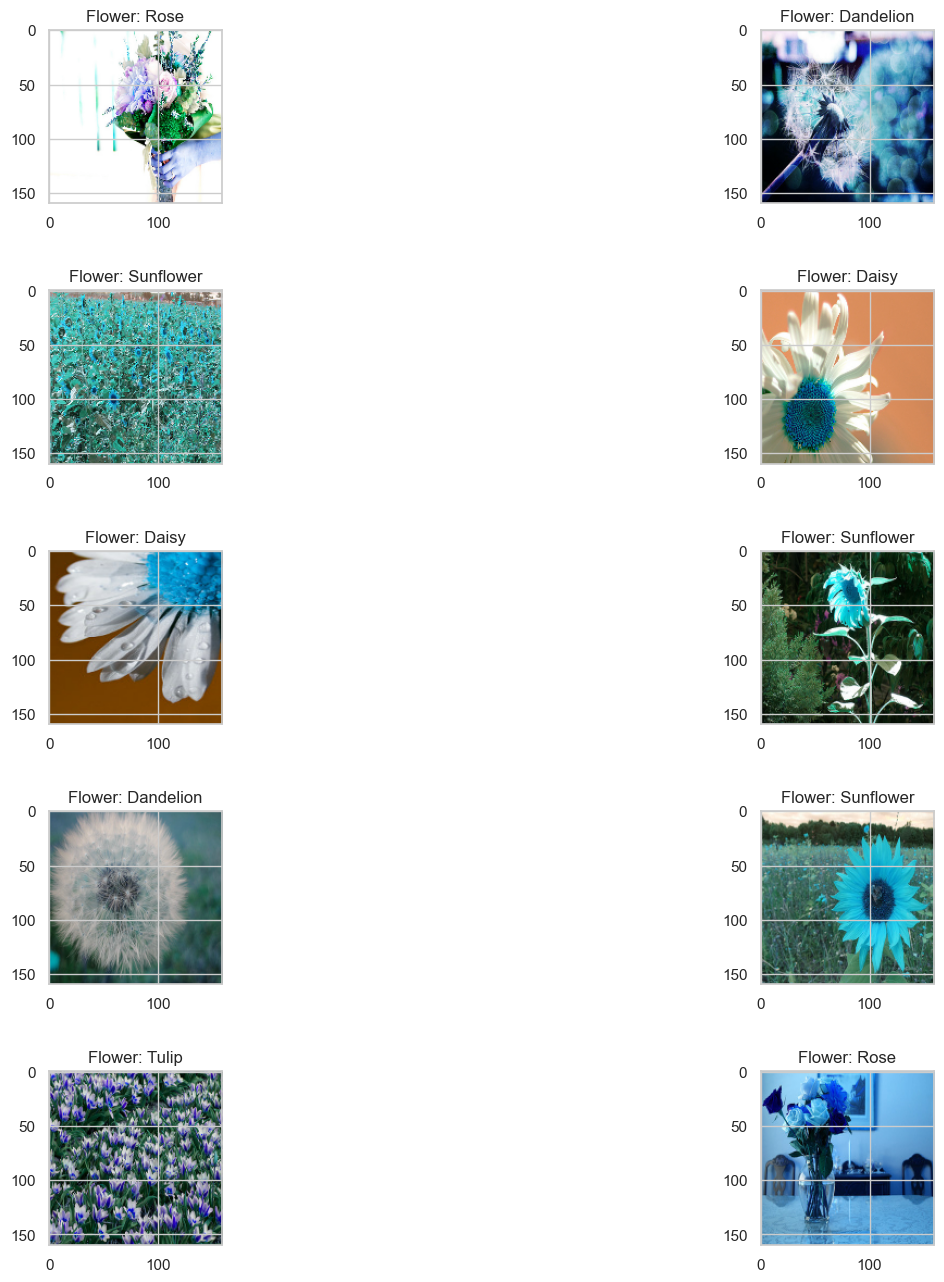

In [13]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: {}'.format(Z[l]))
        
plt.subplots_adjust(hspace=0.5)
plt.show()

In [14]:
# Perform label encoding for Y
le = LabelEncoder()
y = le.fit_transform(Z)

# Print unique labels to check their values
print("Unique Labels:", np.unique(y))

# Perform one-hot encoding for Y
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

print("one hot encoded:", y)

# Convert X to numpy array and normalize
X = np.array(X)
X = X / 255.0

Unique Labels: [0 1 2 3 4]
one hot encoded: [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [16]:
# Set the random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

### Building the ConvNet Model


In [17]:
# Define CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Adjust the number of units in the output layer to match the number of classes
model.add(Dense(num_classes, activation='softmax'))

In [18]:
# LR(learning rate) Annealer usage
batch_size = 128
epochs = 30

red_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1)

In [19]:
# Create an instance of the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(X_train)

In [20]:
# Set a learning rate
learning_rate = 0.001

# Compile the model with the selected learning rate
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 77, 77, 128)      5

In [21]:
# Fitting the model with augmented data
History = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, y_test),
                    verbose=1, workers=4)

Epoch 1/30
17/17 [==============================] - 334s 19s/step - loss: 2.2449 - accuracy: 0.4356 - val_loss: 26.0302 - val_accuracy: 0.2475
Epoch 2/30
17/17 [==============================] - 316s 18s/step - loss: 1.4964 - accuracy: 0.5027 - val_loss: 30.9276 - val_accuracy: 0.2475
Epoch 3/30
17/17 [==============================] - 246s 14s/step - loss: 1.3423 - accuracy: 0.5367 - val_loss: 13.6775 - val_accuracy: 0.2475
Epoch 4/30
17/17 [==============================] - 285s 17s/step - loss: 1.2518 - accuracy: 0.5590 - val_loss: 11.1577 - val_accuracy: 0.2475
Epoch 5/30
17/17 [==============================] - 269s 16s/step - loss: 1.2010 - accuracy: 0.5629 - val_loss: 6.4326 - val_accuracy: 0.2475
Epoch 6/30
17/17 [==============================] - 236s 14s/step - loss: 1.1955 - accuracy: 0.5964 - val_loss: 4.9155 - val_accuracy: 0.2504
Epoch 7/30
17/17 [==============================] - 248s 14s/step - loss: 1.1310 - accuracy: 0.5911 - val_loss: 5.3680 - val_accuracy: 0.2489
Ep

In [22]:
model_summary = pd.DataFrame(History.history)
model_summary.tail()

loss  accuracy  val_loss  val_accuracy
25  0.687637  0.732880  1.594839      0.445415
26  0.718909  0.723652  2.910100      0.398836
27  0.781216  0.700826  1.879663      0.459971
28  0.770923  0.716367  1.422836      0.547307
29  0.706640  0.734337  1.215562      0.582242

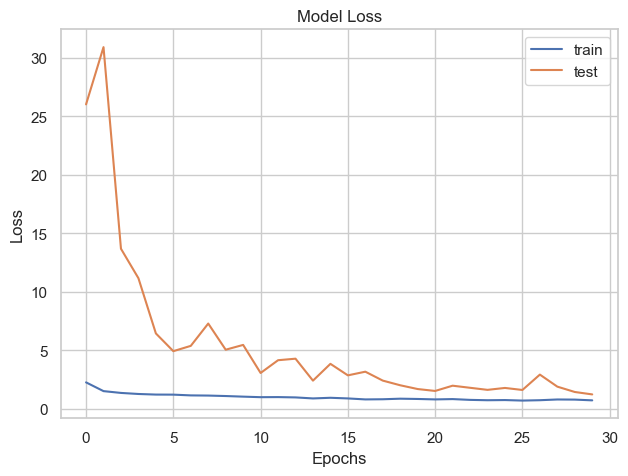

In [23]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

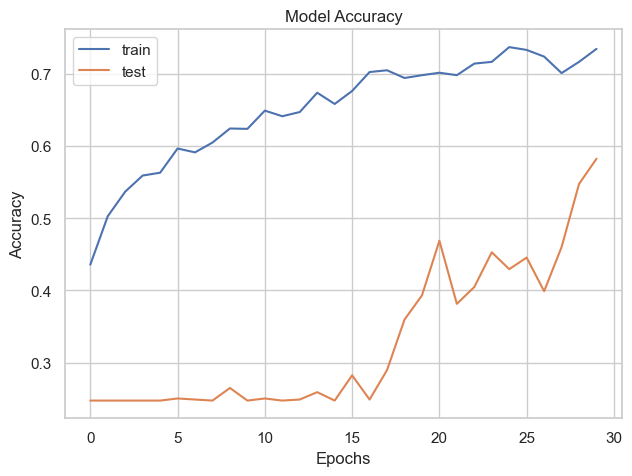

In [24]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [25]:
# getting predictions on value set
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)

In [26]:
# Store misclassified and proper indexes
i = 0
proper_class = []
misclassified_class = []

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
       proper_class.append(i)
    if(len(proper_class) == 12):
       break

i = 0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i]) == pred_digits[i]):       
       misclassified_class.append(i)
    if(len(misclassified_class) == 12):
       break

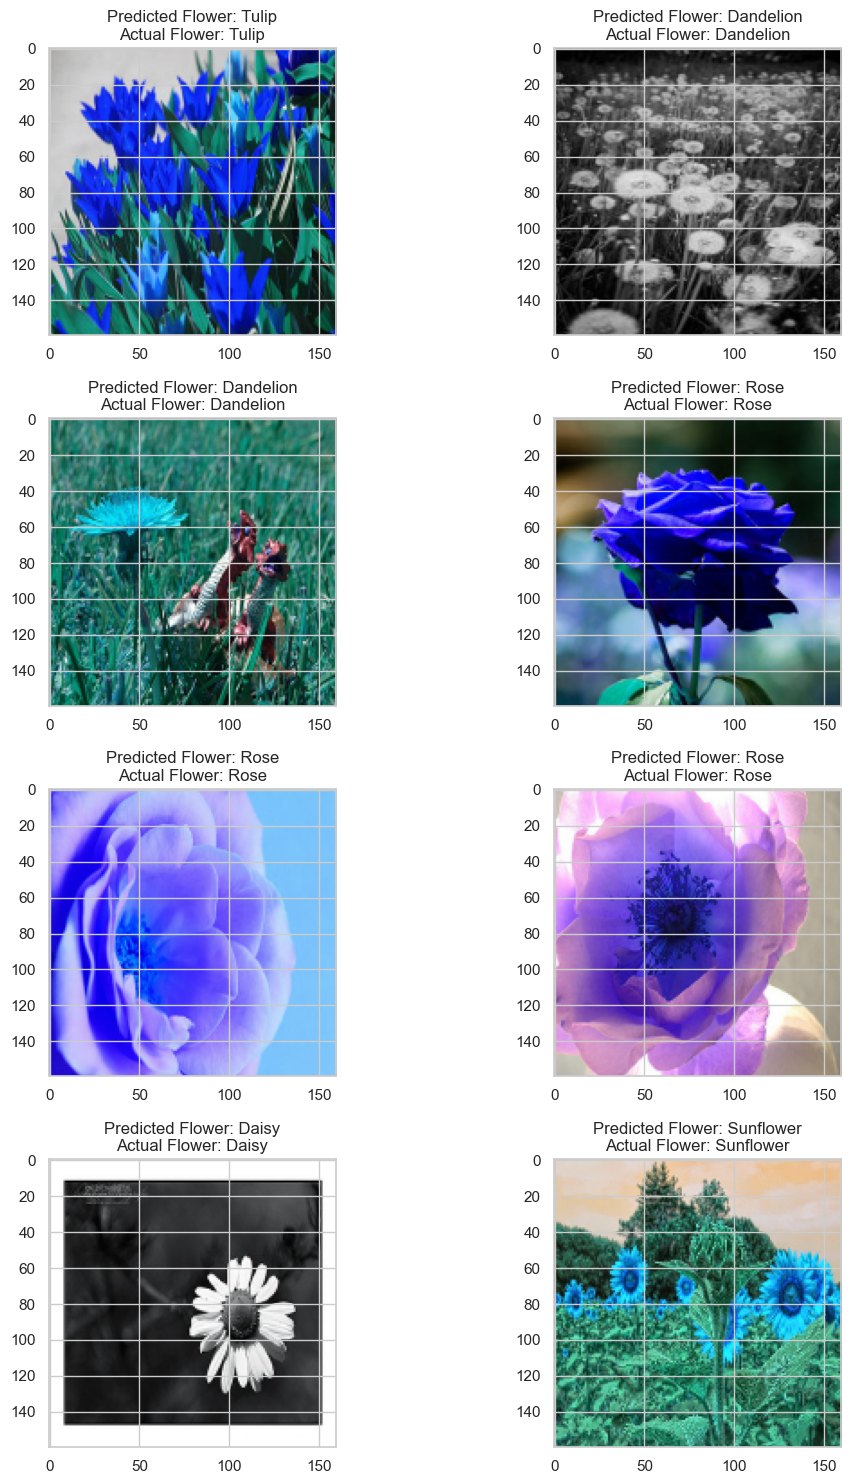

In [27]:
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(X_test[proper_class[count]])
        ax[i, j].set_title("Predicted Flower: " + str(le.inverse_transform(np.array([pred_digits[proper_class[count]]]).reshape(1, -1))[0]) + "\n" + "Actual Flower: " + str(le.inverse_transform(np.argmax([y_test[proper_class[count]]]).reshape(1, -1))[0]))
        plt.tight_layout()
        count+=1

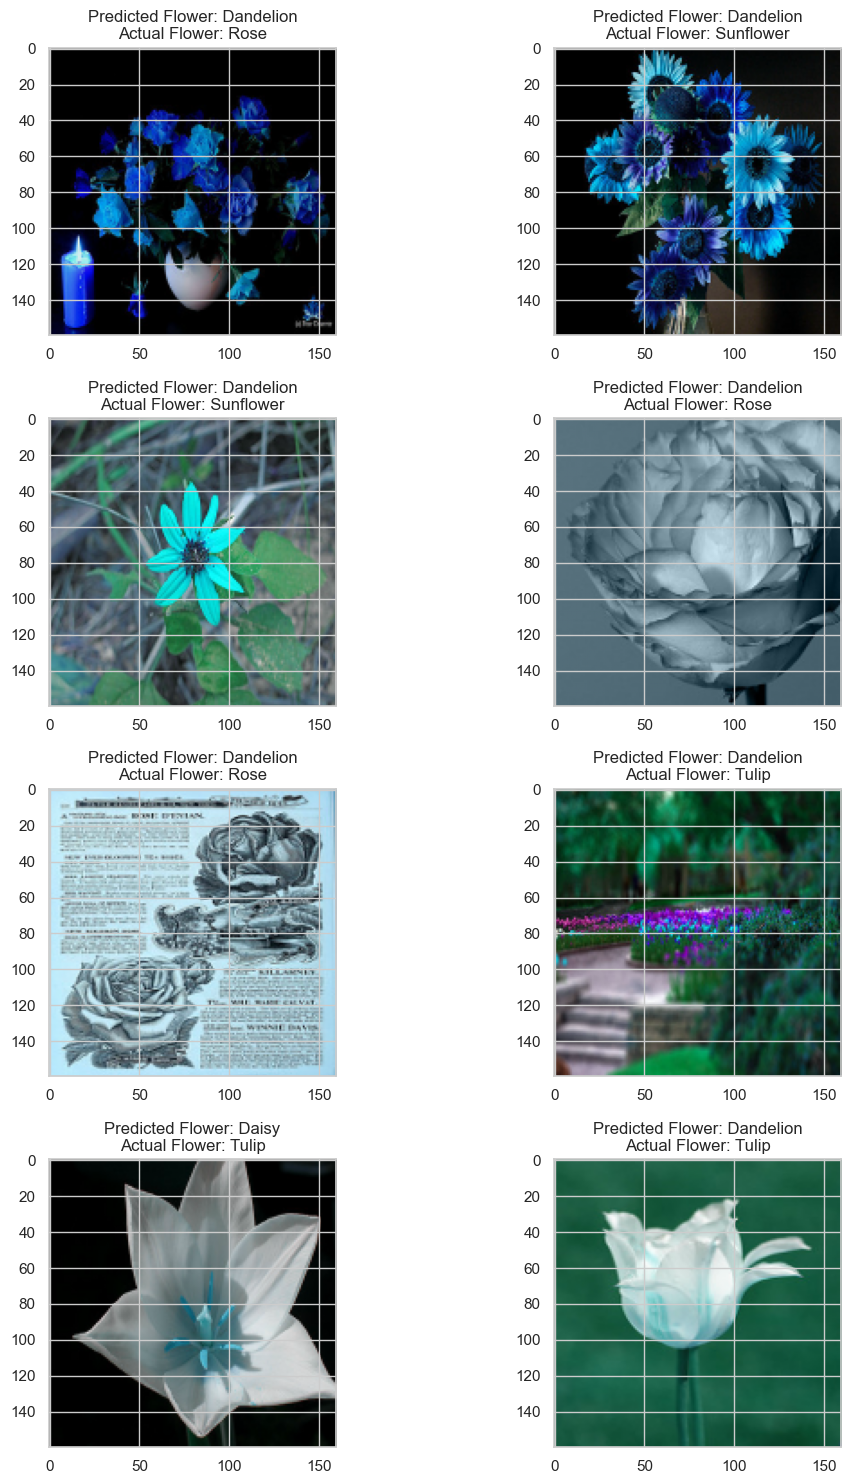

In [28]:
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(X_test[misclassified_class[count]])
        ax[i, j].set_title("Predicted Flower: " + str(le.inverse_transform(np.array([pred_digits[misclassified_class[count]]]).reshape(1, -1))[0]) + "\n" + "Actual Flower: " + str(le.inverse_transform(np.argmax([y_test[misclassified_class[count]]]).reshape(1, -1))[0]))
        plt.tight_layout()
        count+=1

In [36]:
test_folder = 'test/'
img_width, img_height = 160, 160  # Adjust these dimensions based on your model's input size

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img

# Get a list of all image files in the 'test' folder
test_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Make predictions for each test image
predictions = []
for file_path in test_files:
    img = load_and_preprocess_image(file_path)
    pred = model.predict(img)
    predictions.append(np.argmax(pred, axis=1)[0])

# Display the predictions
print("Predictions:", predictions)

Predictions: [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 1, 1, 1, 1, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 4, 1, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 0, 1, 1, 1, 0, 4, 1, 1, 1, 1, 1, 4, 1, 4, 0, 1, 1, 1, 1]


In [38]:
# Store misclassified and proper indexes
proper_class = []
misclassified_class = []

# Assuming 'y_test' contains the true labels for your test data
for i in range(len(y_test)):
    img_path = test_files[i]  # Get the corresponding image path
    img = load_and_preprocess_image(img_path)  # Load and preprocess the image
    pred = model.predict(img)
    predicted_label = np.argmax(pred, axis=1)[0]
    
    if np.argmax(y_test[i]) == predicted_label:
        proper_class.append(i)
    if len(proper_class) == 12:
        break

for i in range(len(y_test)):
    img_path = test_files[i]  # Get the corresponding image path
    img = load_and_preprocess_image(img_path)  # Load and preprocess the image
    pred = model.predict(img)
    predicted_label = np.argmax(pred, axis=1)[0]

    if not np.argmax(y_test[i]) == predicted_label:
        misclassified_class.append(i)
    if len(misclassified_class) == 12:
        break

# Display the indexes of properly and misclassified images
print("Properly Classified Indexes:", proper_class)
print("Misclassified Indexes:", misclassified_class)


Properly Classified Indexes: [3, 14, 19, 22, 27, 34, 35, 39, 41, 44, 45, 59]
Misclassified Indexes: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]


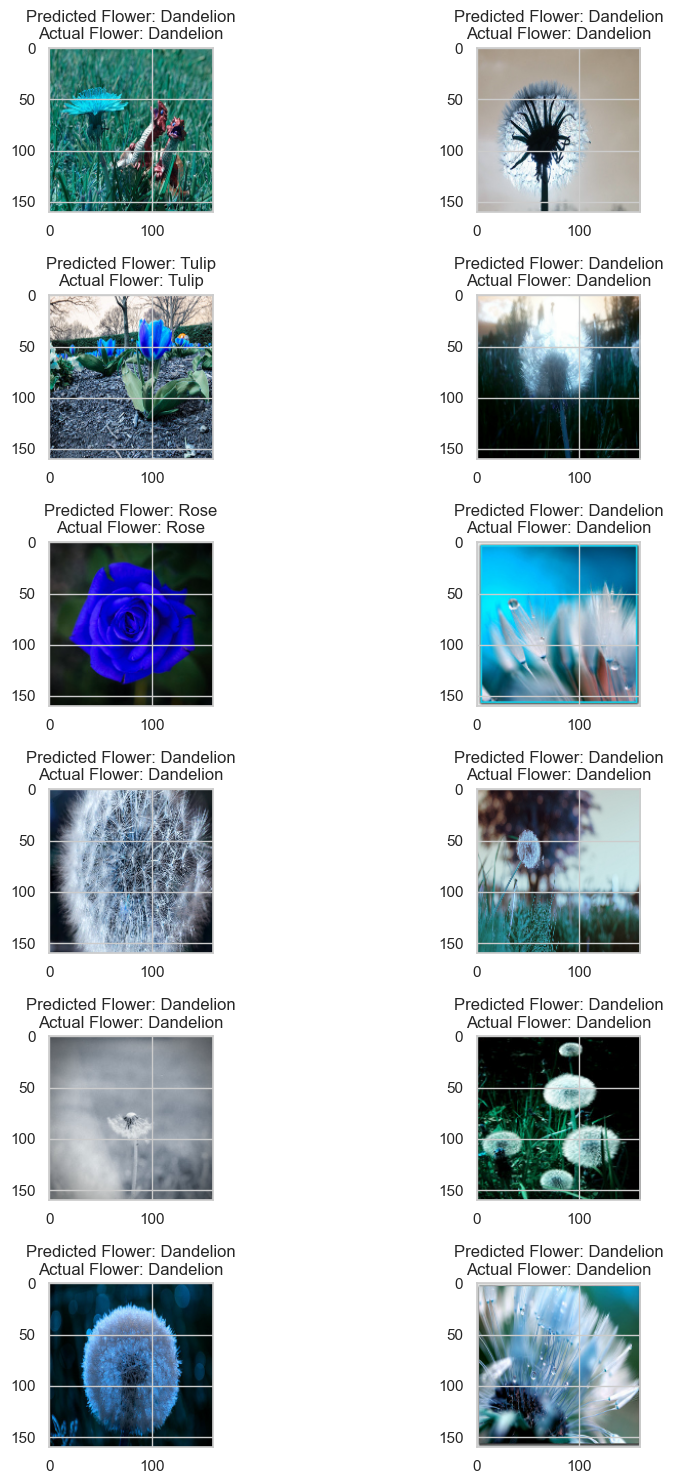

In [69]:
count = 0
fig, ax = plt.subplots(len(proper_class)//2, 2)  # Adjust the subplot layout based on the number of proper images
fig.set_size_inches(15, 15)

for i in range(len(proper_class)//2):
    for j in range(2):
        idx = proper_class[count]
        ax[i, j].imshow(X_test[idx])
        ax[i, j].set_title("Predicted Flower: " + str(le.inverse_transform(np.array([pred_digits[idx]]))[0]) + "\n" +
                          "Actual Flower: " + str(le.inverse_transform(np.argmax(y_test[idx].reshape(1, -1), axis=1))[0]))
        plt.tight_layout()
        count += 1
        if count >= len(proper_class):
            break


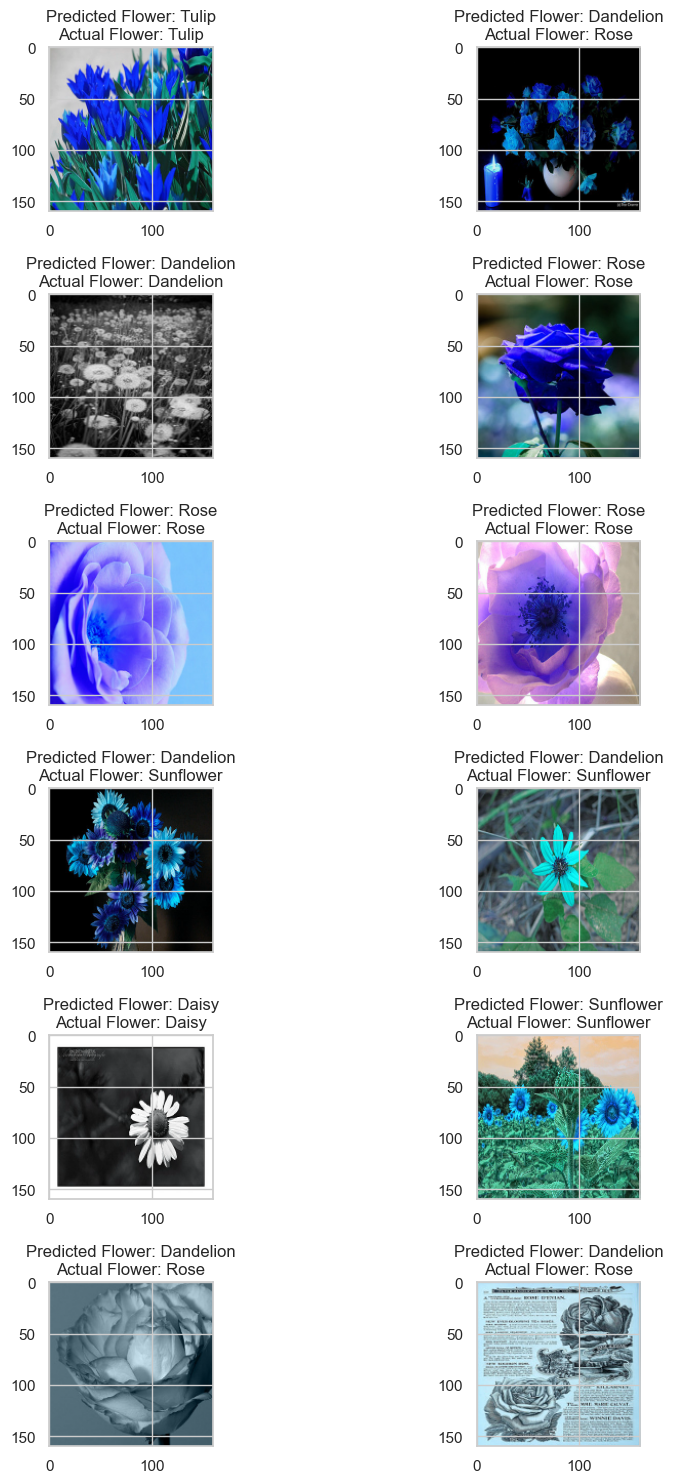

In [70]:
count = 0
fig, ax = plt.subplots(len(misclassified_class)//2, 2)  # Adjust the subplot layout based on the number of misclassified images
fig.set_size_inches(15, 15)

for i in range(len(misclassified_class)//2):
    for j in range(2):
        idx = misclassified_class[count]
        ax[i, j].imshow(X_test[idx])
        ax[i, j].set_title("Predicted Flower: " + str(le.inverse_transform(np.array([pred_digits[idx]]))[0]) + "\n" +
                          "Actual Flower: " + str(le.inverse_transform(np.argmax(y_test[idx].reshape(1, -1), axis=1))[0]))
        plt.tight_layout()
        count += 1
        if count >= len(misclassified_class):
            break

plt.show()

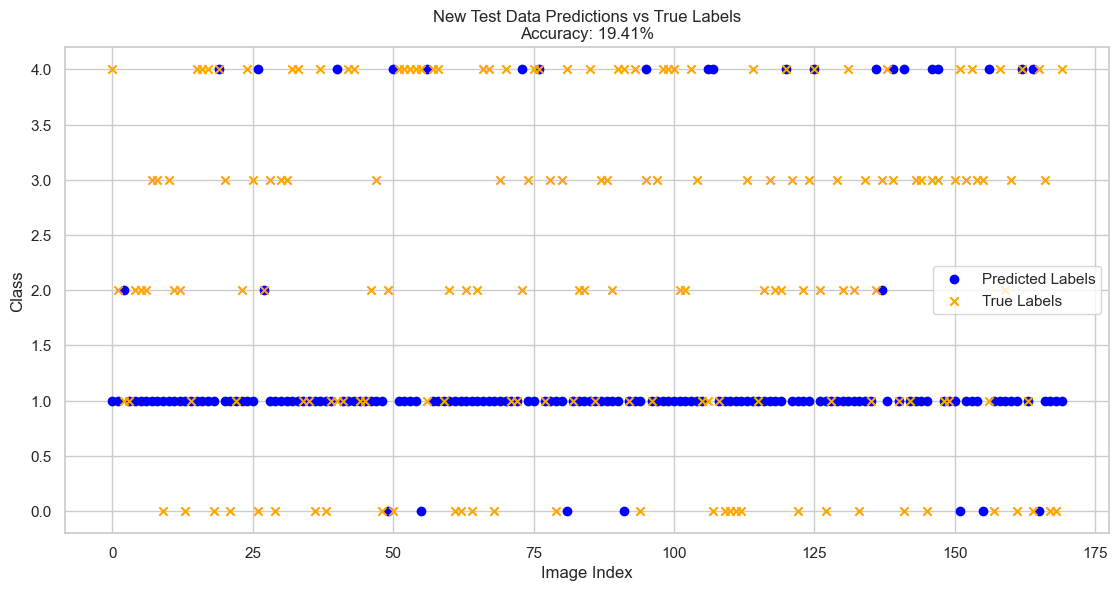

In [58]:
# Create an array of image indices for the x-axis
image_indices = np.arange(len(predictions))

# Get the true labels for the new test data
true_labels = [np.argmax(y_test[i]) for i in range(len(predictions))]

# Calculate the ratio of correctly labeled predictions
correct_predictions = np.sum(np.array(predictions) == np.array(true_labels))
total_predictions = len(predictions)
accuracy_ratio = correct_predictions / total_predictions

# Plot new test data predictions alongside true labels
plt.figure(figsize=(12, 6))

# Scatter plot for predicted labels
plt.scatter(image_indices, predictions, label='Predicted Labels', marker='o', color='blue')

# Scatter plot for true labels
plt.scatter(image_indices, true_labels, label='True Labels', marker='x', color='orange')

plt.title(f'New Test Data Predictions vs True Labels\nAccuracy: {accuracy_ratio:.2%}')
plt.xlabel('Image Index')
plt.ylabel('Class')
plt.legend()
plt.show()